In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
file_path = 'knn_imputation.xlsx'  
df = pd.read_excel(file_path)

here are functions I will use a lot

In [ ]:
def generate_plots(y,y_pred, model_name, flag):
    if flag == 'Training':
        type_of_data = 'Training Data'
    elif flag == 'Testing': 
        type_of_data = 'Testing Data'
    
    residuals = y - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    #this plot is true versus predicted values
    axes[0].scatter(y, y_pred, alpha=0.6)
    axes[0].set_xlabel('True Values for Redshift')
    axes[0].set_ylabel('Predictions')
    axes[0].set_title(model_name + ' on the '+  type_of_data)
    y_equals_x = np.linspace(0, 8, 10)
    axes[0].plot(y_equals_x, y_equals_x, 'r--')  #line with slope 1

    #this plot is for visualizing the residuals
    axes[1].scatter(y, residuals, alpha=0.6)
    axes[1].set_xlabel('True Values for Redshift')
    axes[1].set_ylabel('Residuals (True - Predicted)')
    axes[1].set_title('Residuals vs True Values for Redshift on the ' + type_of_data)
    axes[1].axhline(0, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()

In [4]:
def generate_training_metrics(y,y_pred, model_name):
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(model_name + ' on the full Training Data One Instance')
    print(f"R²: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

In [ ]:
def model_evaluation(model, model_name, X_scaled, y, kfold):
    scoring = {
        'r2': 'r2',
        'neg_mae': 'neg_mean_absolute_error',
        'neg_rmse': 'neg_root_mean_squared_error'
    }

    results = cross_validate(model, X_scaled, y, cv=kfold, scoring=scoring, return_train_score=True)

    r2_train = results['train_r2']
    r2_val = results['test_r2']
    mae_train = -results['train_neg_mae']
    mae_val = -results['test_neg_mae']
    rmse_train = -results['train_neg_rmse']
    rmse_val = -results['test_neg_rmse']

    headers = ["Metric", "Training", "Validation"]
    table = [
        ["R²",   f"{np.mean(r2_train):.2f} ± {np.std(r2_train):.2f}",   f"{np.mean(r2_val):.2f} ± {np.std(r2_val):.2f}"],
        ["MAE",  f"{np.mean(mae_train):.2f} ± {np.std(mae_train):.2f}", f"{np.mean(mae_val):.2f} ± {np.std(mae_val):.2f}"],
        ["RMSE", f"{np.mean(rmse_train):.2f} ± {np.std(rmse_train):.2f}", f"{np.mean(rmse_val):.2f} ± {np.std(rmse_val):.2f}"]
    ]

    print(f"\nCross-Validation Results for {model_name}")
    print(tabulate(table, headers=headers, tablefmt="github"))

    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)
    generate_plots(y, y_pred, model_name, 'Training')
    generate_training_metrics(y, y_pred, model_name)


In [ ]:
def evaluate_model_on_test(model, X_test, y_test, scaler):
    X_test_scaled = scaler.transform(X_test)
    
    y_pred = model.predict(X_test_scaled).flatten()
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"R²:    {r2:.2f}")
    print(f"MAE:   {mae:.2f}")
    print(f"RMSE:  {rmse:.2f}")

prep our data for all the models

In [7]:
X_initial = df.drop(columns=['GRB', 'Redshift'])
y_initial = df['Redshift']

X_train, X_test, y_train, y_test = train_test_split(X_initial, y_initial, test_size=0.2)
#do not touch X_test and y_test until the very end.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
y = y_train

#below is k fold cross validation but only performed once
kfold = KFold(n_splits=5, shuffle=True) #we wipe this variable out in the next line
#below is kfold validation but performed about 20 times
kfold = RepeatedKFold(n_splits=5, n_repeats=4)

In [8]:
print(X_test.shape)

(84, 41)


now we can start building models!

build a multivariable linear regression model


Cross-Validation Results for Multivariable Linear Regression
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.41 ± 0.02 | 0.13 ± 0.14  |
| MAE      | 0.84 ± 0.02 | 0.99 ± 0.09  |
| RMSE     | 1.05 ± 0.02 | 1.26 ± 0.15  |


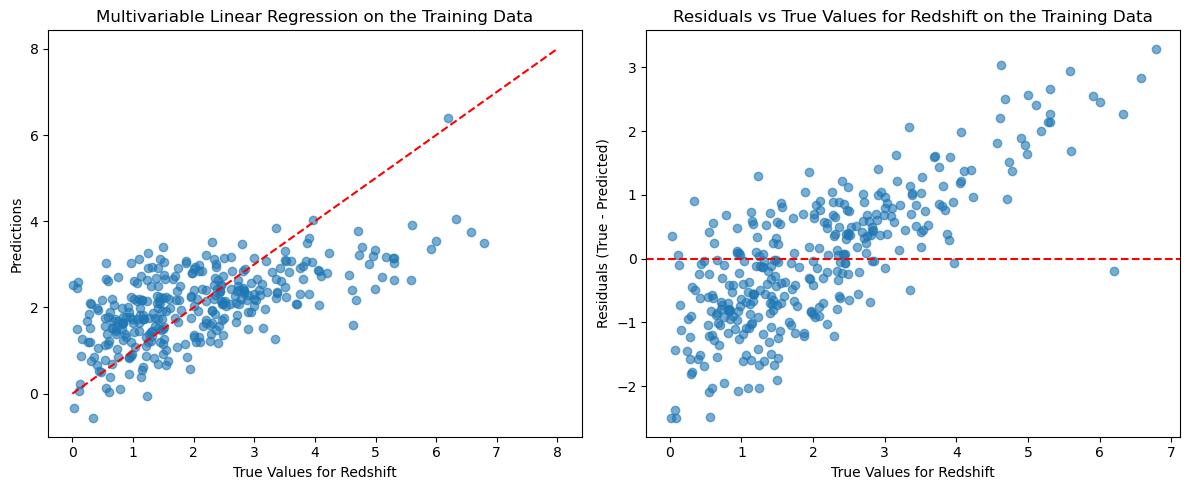

Multivariable Linear Regression on the full Training Data One Instance
R²: 0.39
MAE: 0.85
RMSE: 1.07


In [96]:
model = LinearRegression()
model_name = 'Multivariable Linear Regression'
model_evaluation(model,model_name, X_scaled,y,kfold)

now let us try optimizing our linear regression model, we will try ridge and lasso regression

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge()
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 110, 120, 150, 500, 1000]  #alpha controls how much regularization is applied
}
param_grid = {
    'alpha': np.linspace(90,170,20)  #alpha controls how much regularization is applied
}
grid = GridSearchCV(ridge, param_grid, cv=kfold, scoring='r2')
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print('The optimal Parameter is', grid.best_params_['alpha'])

The optimal Parameter is 140.5263157894737



Cross-Validation Results for Ridge Regression with best alpha
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.34 ± 0.02 | 0.19 ± 0.06  |
| MAE      | 0.88 ± 0.02 | 0.96 ± 0.08  |
| RMSE     | 1.11 ± 0.02 | 1.21 ± 0.09  |


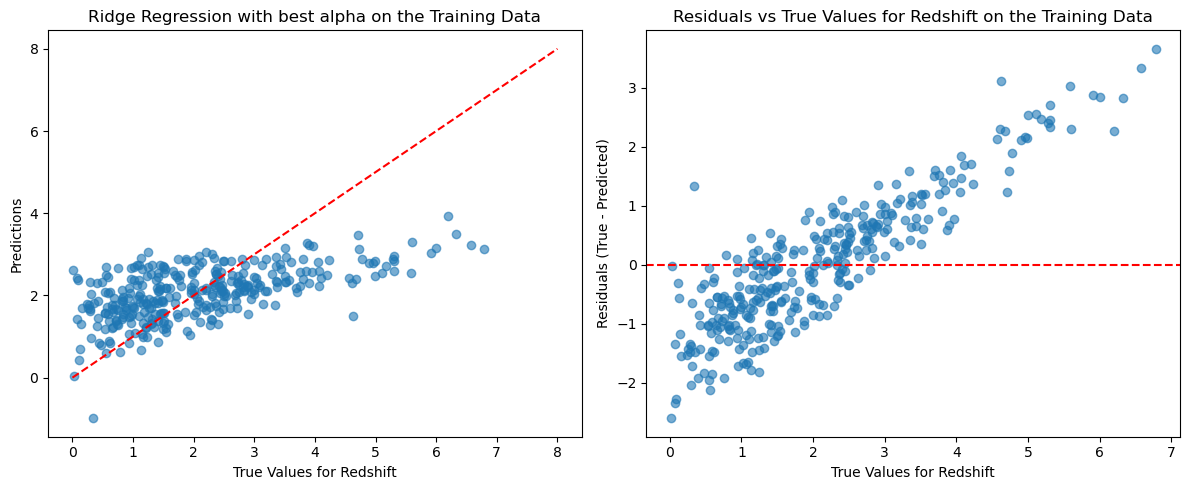

Ridge Regression with best alpha on the full Training Data One Instance
R²: 0.33
MAE: 0.88
RMSE: 1.12


In [11]:
model = Ridge(alpha=grid.best_params_['alpha'])
model_name = 'Ridge Regression with best alpha'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [12]:
evaluate_model_on_test(model, X_test, y_test, scaler)

R²:    0.36
MAE:   0.90
RMSE:  1.21


In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(max_iter=10000)
param_grid = {
    'alpha': [0.001, 0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1, 1.0, 10.0, 100.0, 110, 120, 150, 500, 1000]  #alpha controls how much regularization is applied
}

param_grid = {
    'alpha': np.linspace(0.03,0.06,20)  #alpha controls how much regularization is applied
}
grid = GridSearchCV(lasso, param_grid, cv=kfold, scoring='r2')
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print('The optimal Parameter is', grid.best_params_['alpha'])

The optimal Parameter is 0.06


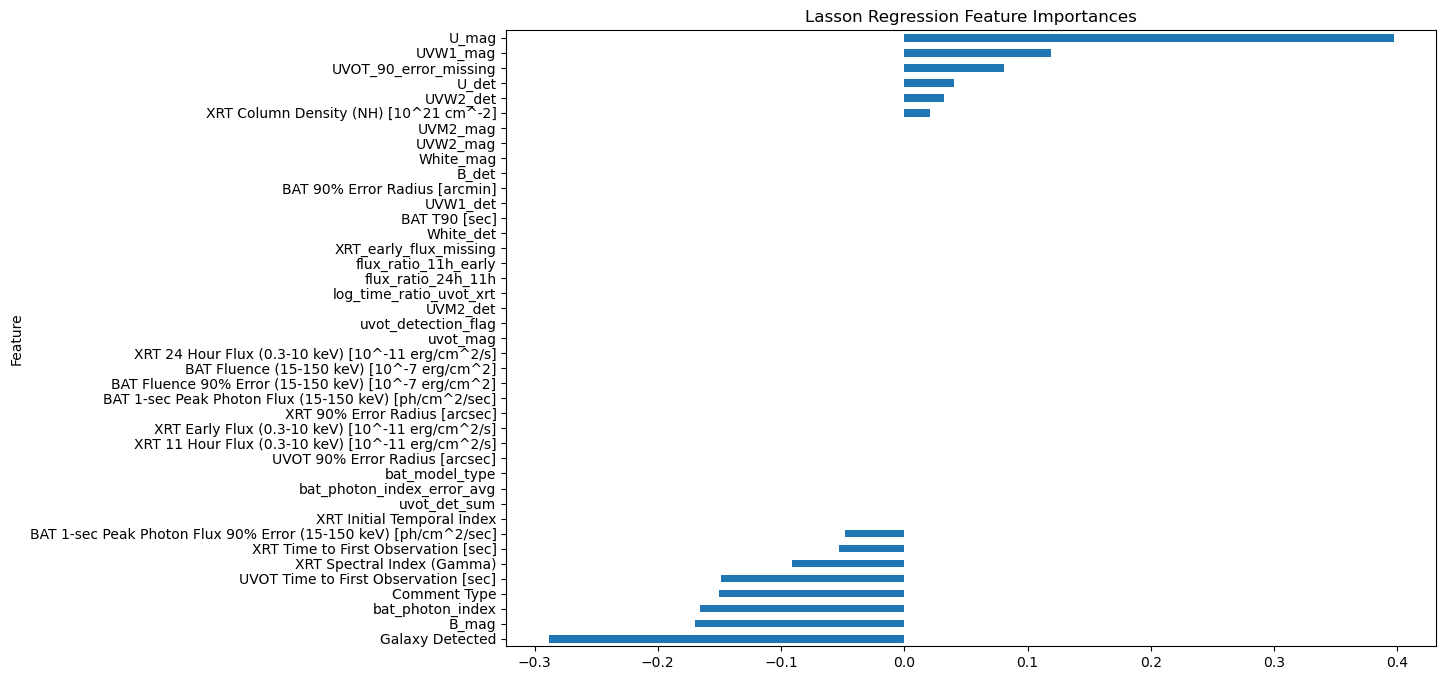

In [14]:
#feature selection
lasso = Lasso(alpha=grid.best_params_['alpha'], max_iter=10000)
lasso.fit(X_scaled, y)

importances = lasso.coef_
feature_names = X_initial.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(12, 8))
plt.title("Lasson Regression Feature Importances")
plt.gca().invert_yaxis()  #helps put the higher importance features at top
plt.show()


Cross-Validation Results for Lasso Regression with the best alpha
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.34 ± 0.02 | 0.21 ± 0.05  |
| MAE      | 0.88 ± 0.02 | 0.95 ± 0.08  |
| RMSE     | 1.11 ± 0.02 | 1.19 ± 0.10  |


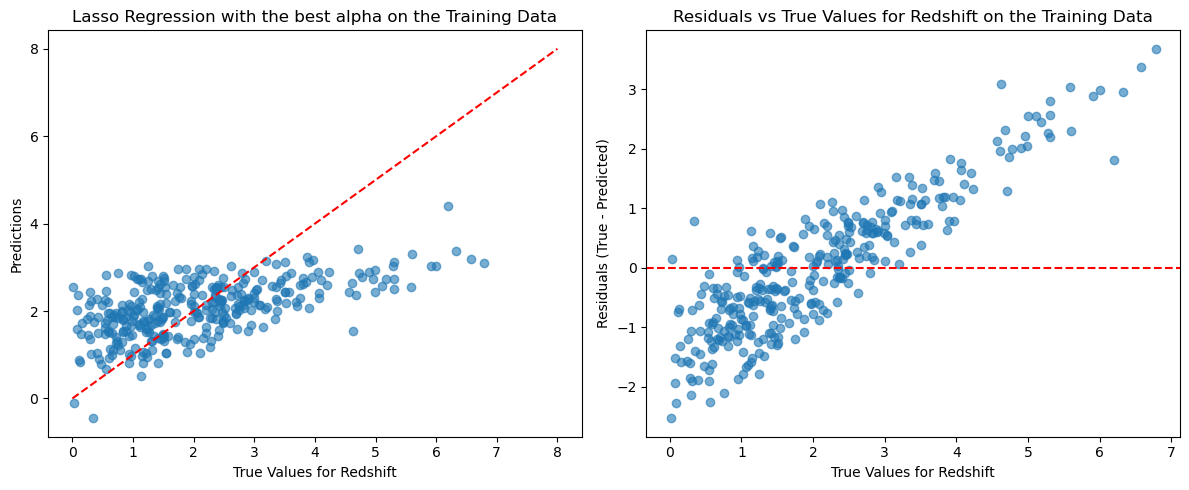

Lasso Regression with the best alpha on the full Training Data One Instance
R²: 0.33
MAE: 0.89
RMSE: 1.12


In [15]:
model = Lasso(alpha=grid.best_params_['alpha'], max_iter=10000)
model_name = 'Lasso Regression with the best alpha'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [16]:
evaluate_model_on_test(model, X_test, y_test, scaler)

R²:    0.35
MAE:   0.92
RMSE:  1.22


In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(max_iter=10000)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0] 
}
param_grid = {
    'alpha': np.linspace(0.05,0.35,20),
    'l1_ratio': np.linspace(0.05,0.65,20) 
}

#alternative scoring mechanism
scoring_mechanism = 'neg_mean_absolute_error' #this isn't a bad scoring mechanism
grid = GridSearchCV(elastic_net, param_grid, cv=kfold, scoring='r2')
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
alpha = grid.best_params_['alpha']
l1 = grid.best_params_['l1_ratio']
print('optimal parameters are', alpha, 'and', l1)

optimal parameters are 0.09736842105263158 and 0.618421052631579



Cross-Validation Results for Elastic Net Regression with best Alpha and L1 Ratio
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.33 ± 0.02 | 0.22 ± 0.10  |
| MAE      | 0.88 ± 0.02 | 0.95 ± 0.08  |
| RMSE     | 1.11 ± 0.02 | 1.19 ± 0.10  |


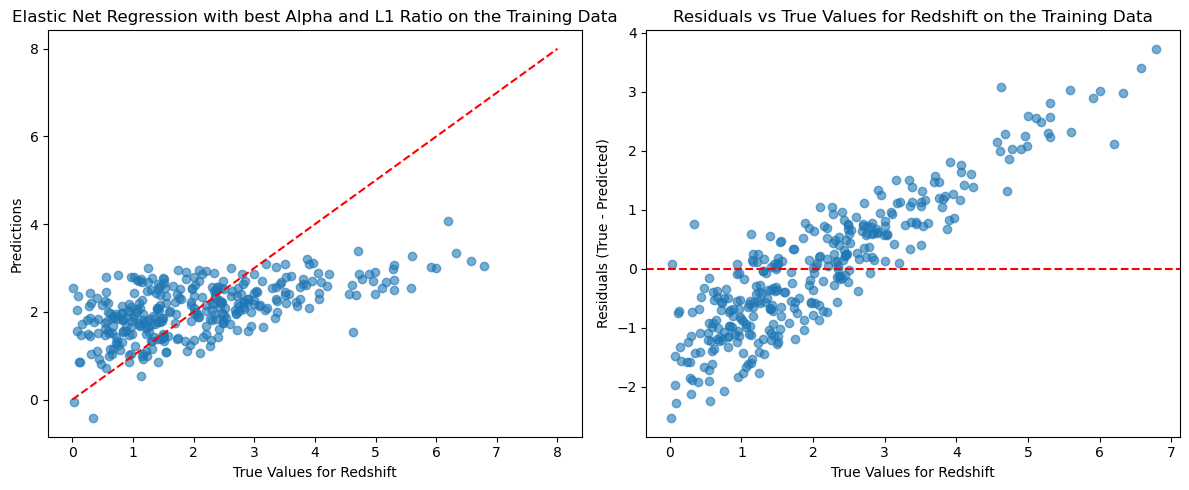

Elastic Net Regression with best Alpha and L1 Ratio on the full Training Data One Instance
R²: 0.32
MAE: 0.89
RMSE: 1.13


In [18]:
model = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
model_name = 'Elastic Net Regression with best Alpha and L1 Ratio'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [19]:
evaluate_model_on_test(model, X_test, y_test, scaler)

R²:    0.34
MAE:   0.92
RMSE:  1.22



Cross-Validation Results for K Nearest Neighbors
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.37 ± 0.02 | 0.14 ± 0.13  |
| MAE      | 0.84 ± 0.02 | 0.97 ± 0.07  |
| RMSE     | 1.09 ± 0.03 | 1.25 ± 0.09  |


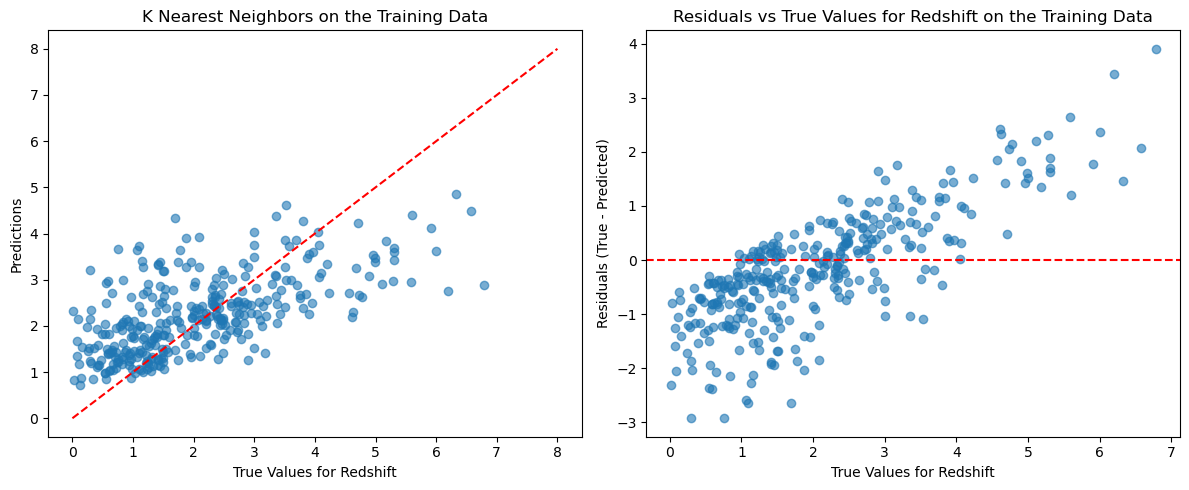

K Nearest Neighbors on the full Training Data One Instance
R²: 0.38
MAE: 0.83
RMSE: 1.07


In [ ]:
model = KNeighborsRegressor(n_neighbors=7) 
model_name = 'K Nearest Neighbors'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [21]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': np.linspace(1, 20, 20, dtype=int),           
    'weights': ['uniform', 'distance'],    #we are in a very high dimensional space, so distance weighting may be BAD.     
    'p': [1, 2]                                  
}

param_grid = {
    'n_neighbors': np.linspace(1, 20, 20, dtype=int),           
    'p': [1, 2]                                  
}

grid = GridSearchCV(knn, param_grid, cv=kfold, scoring='neg_mean_absolute_error')
grid.fit(X_scaled, y)
best_knn = grid.best_estimator_

neighbors = grid.best_params_['n_neighbors']
#weights = grid.best_params_['weights']
best_distance_selection = grid.best_params_['p']
print('The optimal parameters are for neighbors and distance method:',neighbors, ',', best_distance_selection)

The optimal parameters are for neighbors and distance method: 13 , 1



Cross-Validation Results for K Nearest Neighbors with best parameters
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.34 ± 0.02 | 0.23 ± 0.08  |
| MAE      | 0.85 ± 0.03 | 0.92 ± 0.10  |
| RMSE     | 1.11 ± 0.03 | 1.19 ± 0.12  |


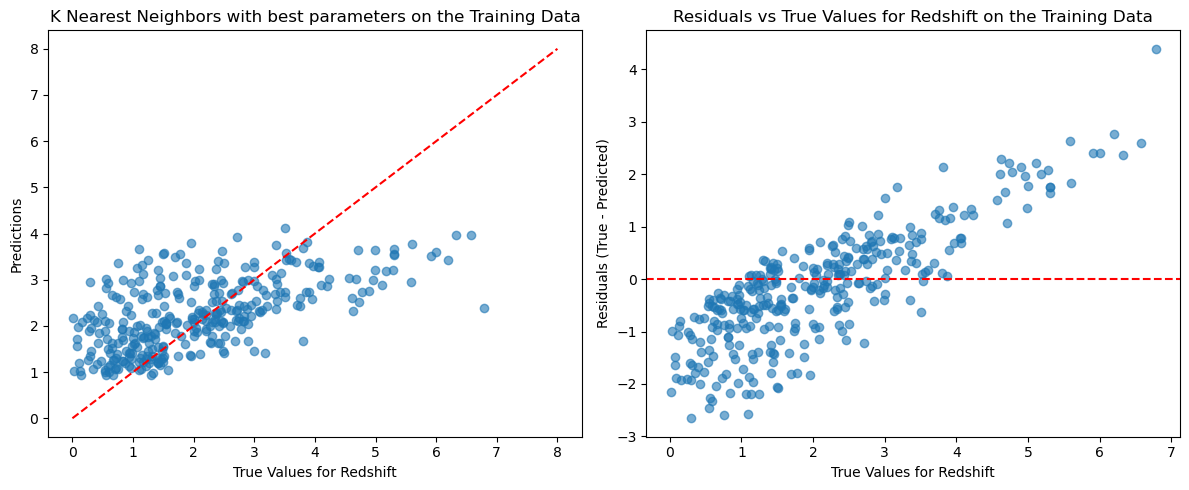

K Nearest Neighbors with best parameters on the full Training Data One Instance
R²: 0.34
MAE: 0.85
RMSE: 1.11


In [48]:
model = KNeighborsRegressor(n_neighbors=neighbors, weights='uniform', p=best_distance_selection)
model_name = 'K Nearest Neighbors with best parameters'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [49]:
evaluate_model_on_test(model, X_test, y_test, scaler)

R²:    0.42
MAE:   0.84
RMSE:  1.15



Cross-Validation Results for Support Vector Regression
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.56 ± 0.02 | 0.26 ± 0.07  |
| MAE      | 0.57 ± 0.02 | 0.87 ± 0.07  |
| RMSE     | 0.90 ± 0.03 | 1.17 ± 0.11  |


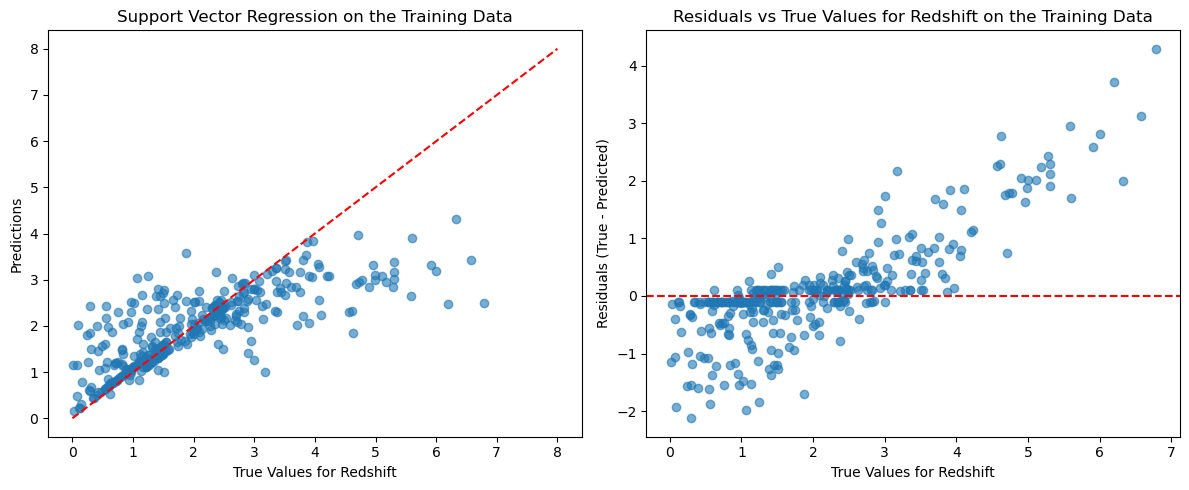

Support Vector Regression on the full Training Data One Instance
R²: 0.56
MAE: 0.58
RMSE: 0.91


In [ ]:
model = svr = SVR()
model_name = 'Support Vector Regression'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],            #this controls the amount of regularization
    'epsilon': [0.01, 0.1, 0.5],    #fits some degree of volume around the data for categorization, this is the width of that tube.
    'gamma': ['scale', 0.01, 0.1, 1]   #smoothness of the kernel, 
}

param_grid = {
    'C': np.linspace(1.5,3.5,10),             #this controls the amount of regularization
    'epsilon': np.linspace(0.2,0.4,20),          #fits some degree of volume around the data for categorization, this is the width of that tube.
    'gamma': ['scale', 0.002, 0.010, 0.015]     #smoothness of the kernel, 
}

grid = GridSearchCV(svr, param_grid, cv=kfold, scoring='r2', n_jobs=-1)
grid.fit(X_scaled, y)
best_svr = grid.best_estimator_
C = grid.best_params_['C']
epsilon = grid.best_params_['epsilon']
gamma = grid.best_params_['gamma']
print('The optimal parameters are for C, epsilon, and gamma:', C, ',', epsilon, ',', gamma)

The optimal parameters are for C, epsilon, and gamma: 1.7222222222222223 , 0.35789473684210527 , 0.015



Cross-Validation Results for Support Vector Regression with best parameters
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.57 ± 0.02 | 0.26 ± 0.10  |
| MAE      | 0.64 ± 0.02 | 0.88 ± 0.07  |
| RMSE     | 0.90 ± 0.02 | 1.16 ± 0.11  |


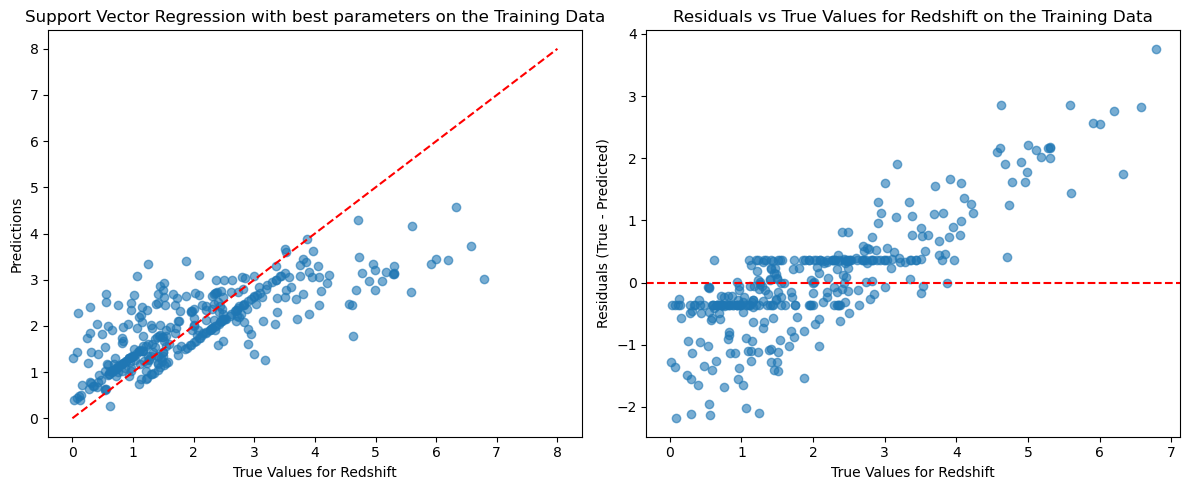

Support Vector Regression with best parameters on the full Training Data One Instance
R²: 0.56
MAE: 0.65
RMSE: 0.90


In [60]:
model = SVR(C=C, epsilon=epsilon, gamma=gamma)
model_name = 'Support Vector Regression with best parameters'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [61]:
evaluate_model_on_test(model, X_test, y_test, scaler)

R²:    0.41
MAE:   0.85
RMSE:  1.16



Cross-Validation Results for Decision Tree Regressor
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.65 ± 0.05 | -0.14 ± 0.27 |
| MAE      | 0.57 ± 0.03 | 1.05 ± 0.12  |
| RMSE     | 0.80 ± 0.06 | 1.41 ± 0.18  |


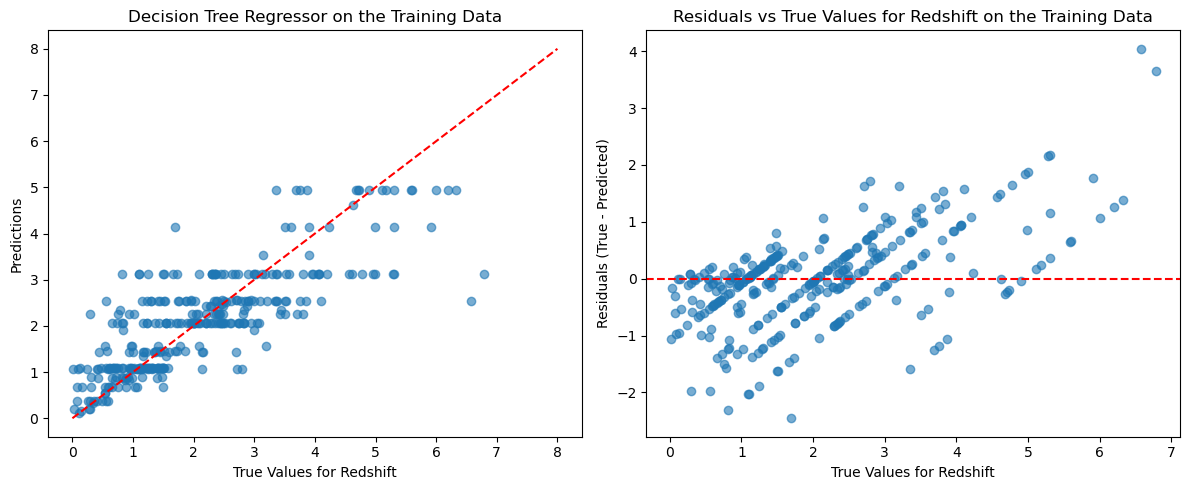

Decision Tree Regressor on the full Training Data One Instance
R²: 0.65
MAE: 0.57
RMSE: 0.81


In [62]:
model = DecisionTreeRegressor(max_depth=5) #these are the hyperparameters I found to be best for this model

model_name = 'Decision Tree Regressor'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [29]:
tree = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

grid_search = GridSearchCV(tree, param_grid, cv=kfold, scoring='r2', n_jobs=-1)
grid_search.fit(X_scaled, y)
best_tree = grid_search.best_estimator_
max_depth = grid_search.best_params_['max_depth']
min_samples_split = grid_search.best_params_['min_samples_split']
min_samples_leaf = grid_search.best_params_['min_samples_leaf']
print('The optimal parameters are for max depth, min samples split, and min samples leaf:', max_depth, ',', min_samples_split, ',', min_samples_leaf)


The optimal parameters are for max depth, min samples split, and min samples leaf: 3 , 9 , 12



Cross-Validation Results for Decision Tree Regressor with best parameters
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.37 ± 0.04 | 0.10 ± 0.15  |
| MAE      | 0.81 ± 0.03 | 0.97 ± 0.08  |
| RMSE     | 1.08 ± 0.04 | 1.28 ± 0.14  |


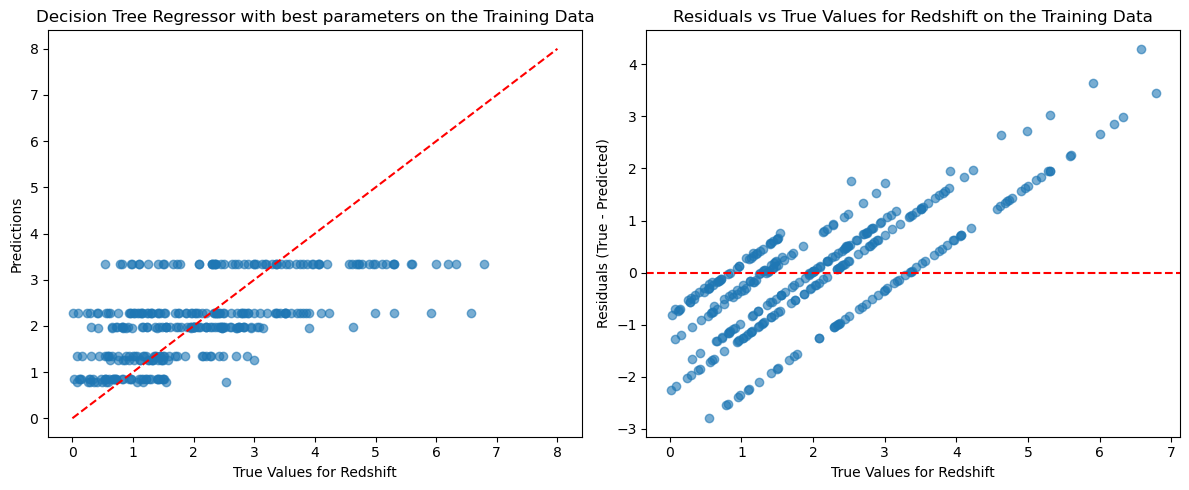

Decision Tree Regressor with best parameters on the full Training Data One Instance
R²: 0.37
MAE: 0.82
RMSE: 1.09


In [63]:
model = DecisionTreeRegressor(max_depth=3, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
model_name = 'Decision Tree Regressor with best parameters'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [64]:
evaluate_model_on_test(model, X_test, y_test, scaler)

R²:    0.35
MAE:   0.91
RMSE:  1.22


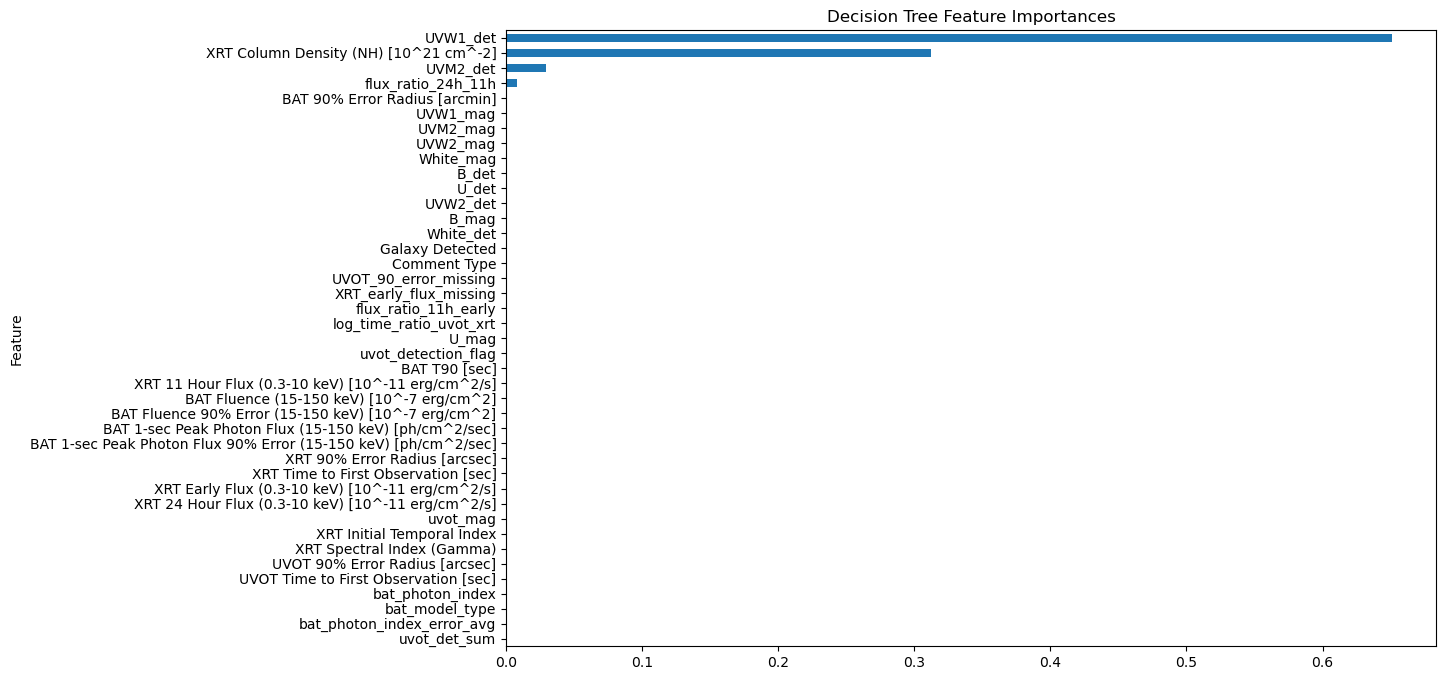

In [26]:
importances = best_tree.feature_importances_
feature_names = X_initial.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(12, 8))
plt.title("Decision Tree Feature Importances")
plt.gca().invert_yaxis()  #helps put the higher importance features at top
plt.show()

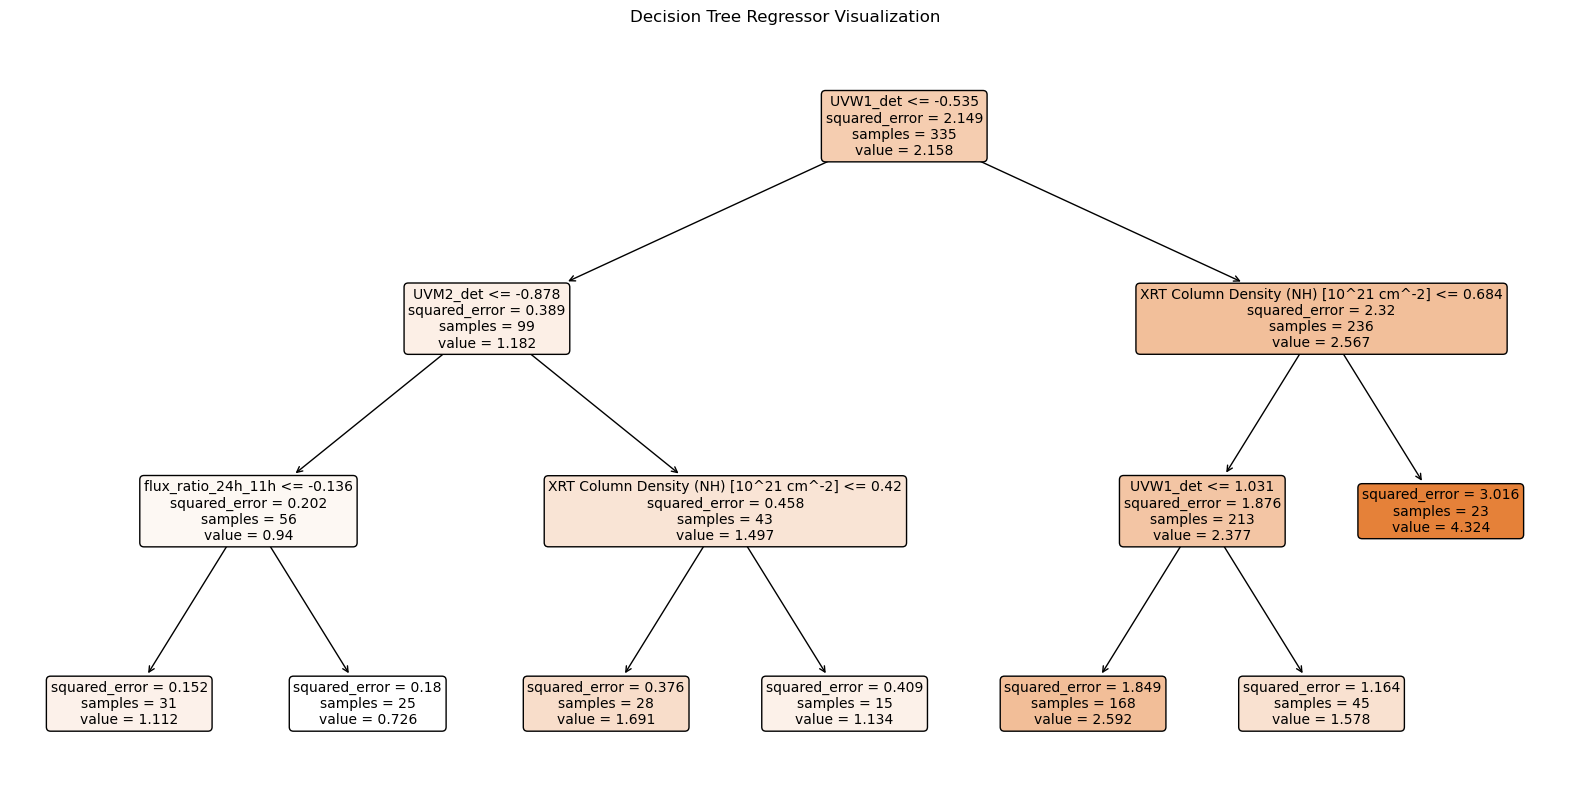

In [27]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10)) 

plot_tree(
    best_tree, 
    feature_names=X_initial.columns, 
    filled=True, 
    rounded=True, 
    max_depth=max_depth,  
    fontsize=10
)
plt.title("Decision Tree Regressor Visualization")
plt.show()


Cross-Validation Results for Random Forest Regressor
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.89 ± 0.01 | 0.30 ± 0.11  |
| MAE      | 0.35 ± 0.01 | 0.87 ± 0.07  |
| RMSE     | 0.45 ± 0.01 | 1.13 ± 0.09  |


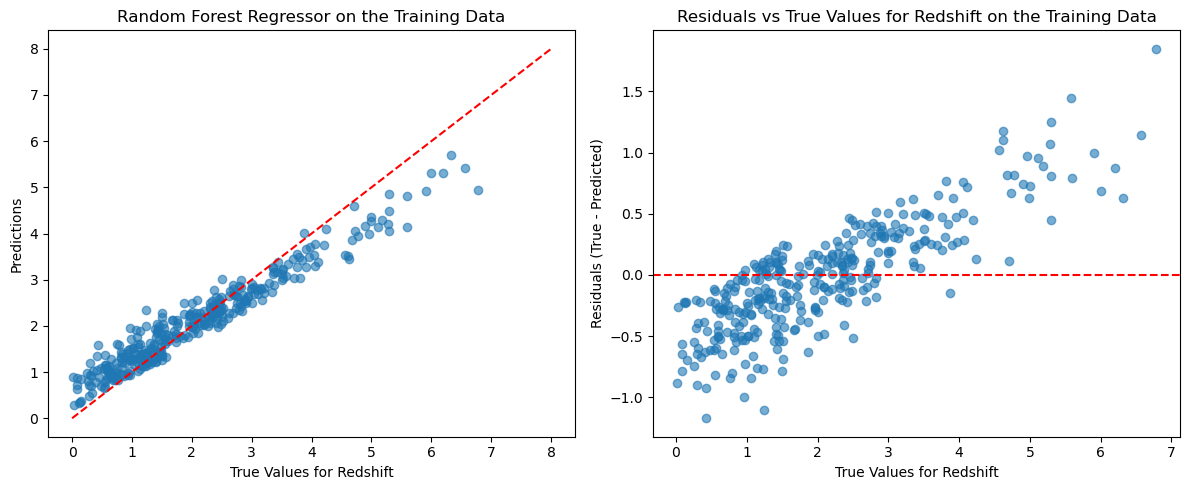

Random Forest Regressor on the full Training Data One Instance
R²: 0.89
MAE: 0.35
RMSE: 0.45


In [65]:
model = RandomForestRegressor(
    n_estimators=100,        
    max_depth=10,         
    n_jobs=-1                
)

model_name = 'Random Forest Regressor'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [29]:
flag = True #if you want paramater tuning set this to true, it's very computationally expensive and takes about 3 minutes.
if flag:
    rf = RandomForestRegressor()

    param_grid = {
        'n_estimators': [100, 200, 300],         
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 7, 10, 12],
        'min_samples_leaf': [1, 2, 4, 6],
    }

    grid = GridSearchCV(rf, param_grid, cv=kfold, scoring='r2', n_jobs=-1)

    grid.fit(X_scaled, y)

    best_rf = grid.best_estimator_
    n_estimators = grid.best_params_['n_estimators']
    max_depth = grid.best_params_['max_depth']
    min_samples_split = grid.best_params_['min_samples_split']
    min_samples_leaf = grid.best_params_['min_samples_leaf']
    print('The optimal parameters are for n estimators, max depth, min samples split, and min samples leaf:', n_estimators, ',', max_depth, ',', min_samples_split, ',', min_samples_leaf)


The optimal parameters are for n estimators, max depth, min samples split, and min samples leaf: 200 , 10 , 7 , 4



Cross-Validation Results for Random Forest Regressor with best parameters
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.61 ± 0.02 | 0.29 ± 0.07  |
| MAE      | 0.66 ± 0.02 | 0.88 ± 0.08  |
| RMSE     | 0.85 ± 0.02 | 1.14 ± 0.10  |


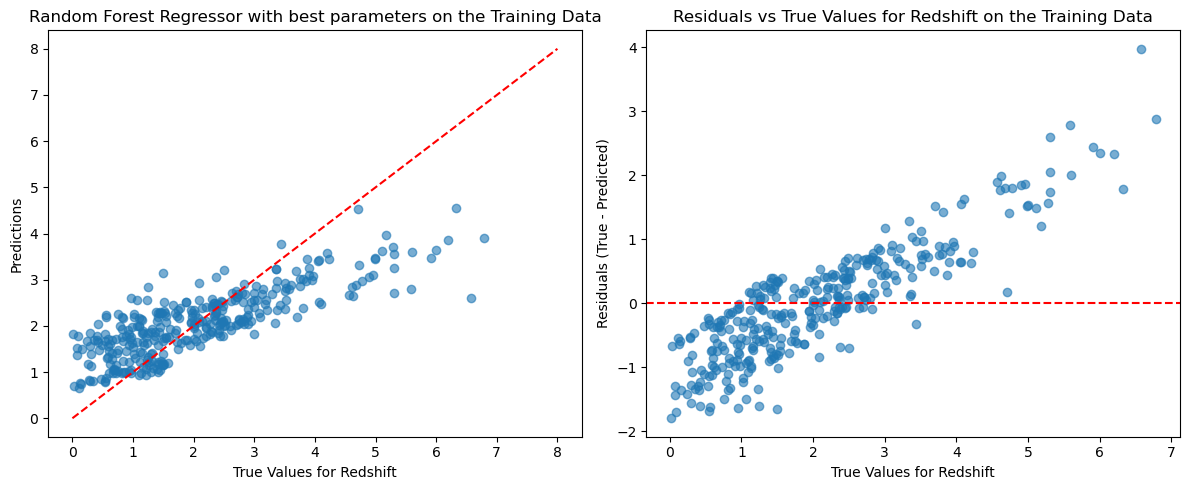

Random Forest Regressor with best parameters on the full Training Data One Instance
R²: 0.58
MAE: 0.68
RMSE: 0.89


In [111]:
#model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
model = RandomForestRegressor(n_estimators=200, max_depth=4, min_samples_split=7, min_samples_leaf=4)

model_name = 'Random Forest Regressor with best parameters'
model_evaluation(model,model_name, X_scaled,y,kfold)

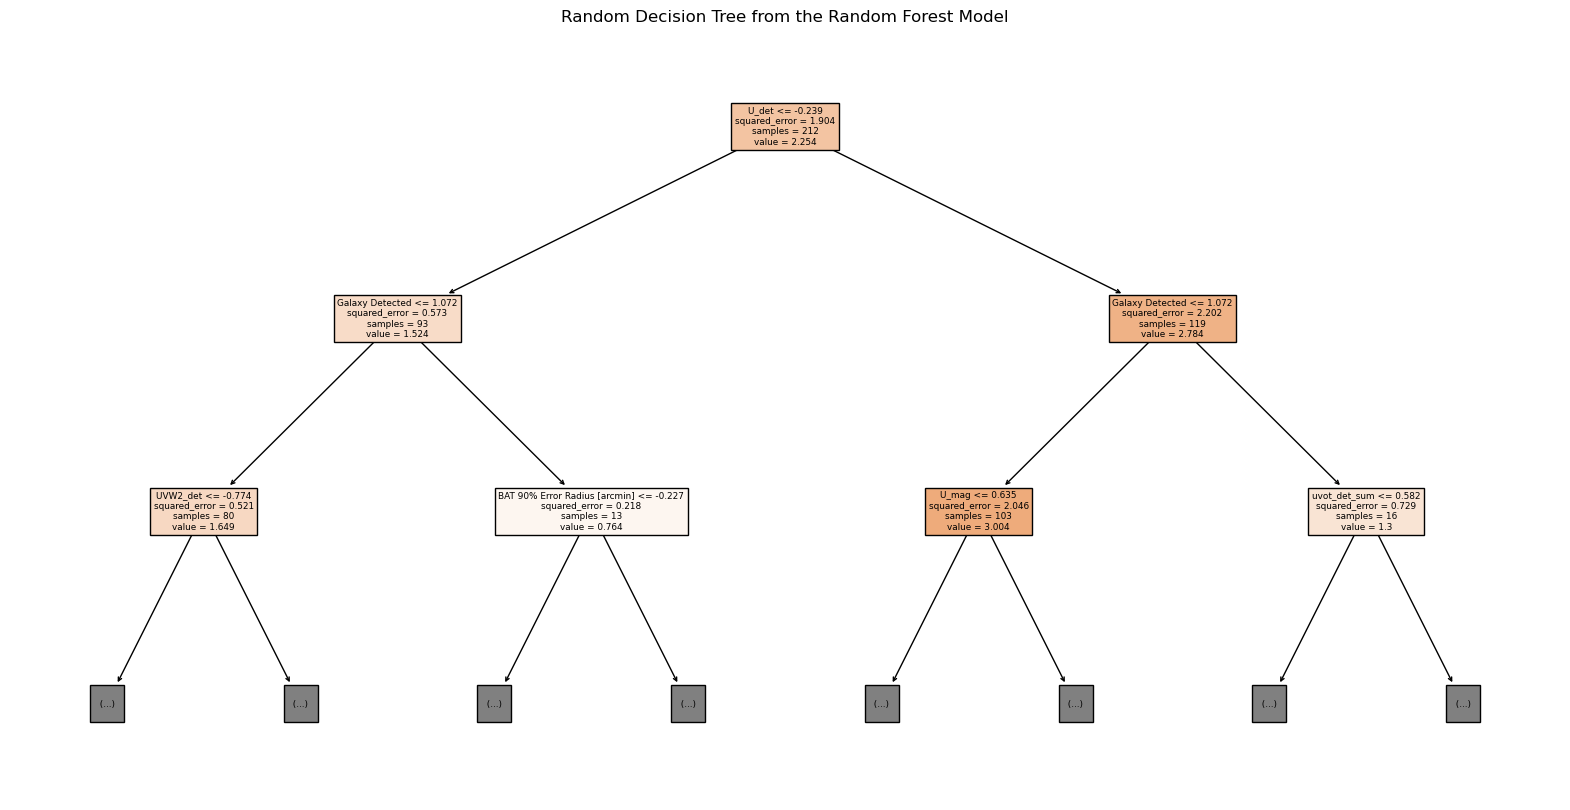

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
tree = model.estimators_[4]
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_initial.columns, class_names=['Low', 'High'], filled=True, max_depth=2)
plt.title("Random Decision Tree from the Random Forest Model")
plt.show()


In [67]:
evaluate_model_on_test(model, X_test, y_test, scaler)

R²:    0.43
MAE:   0.87
RMSE:  1.14


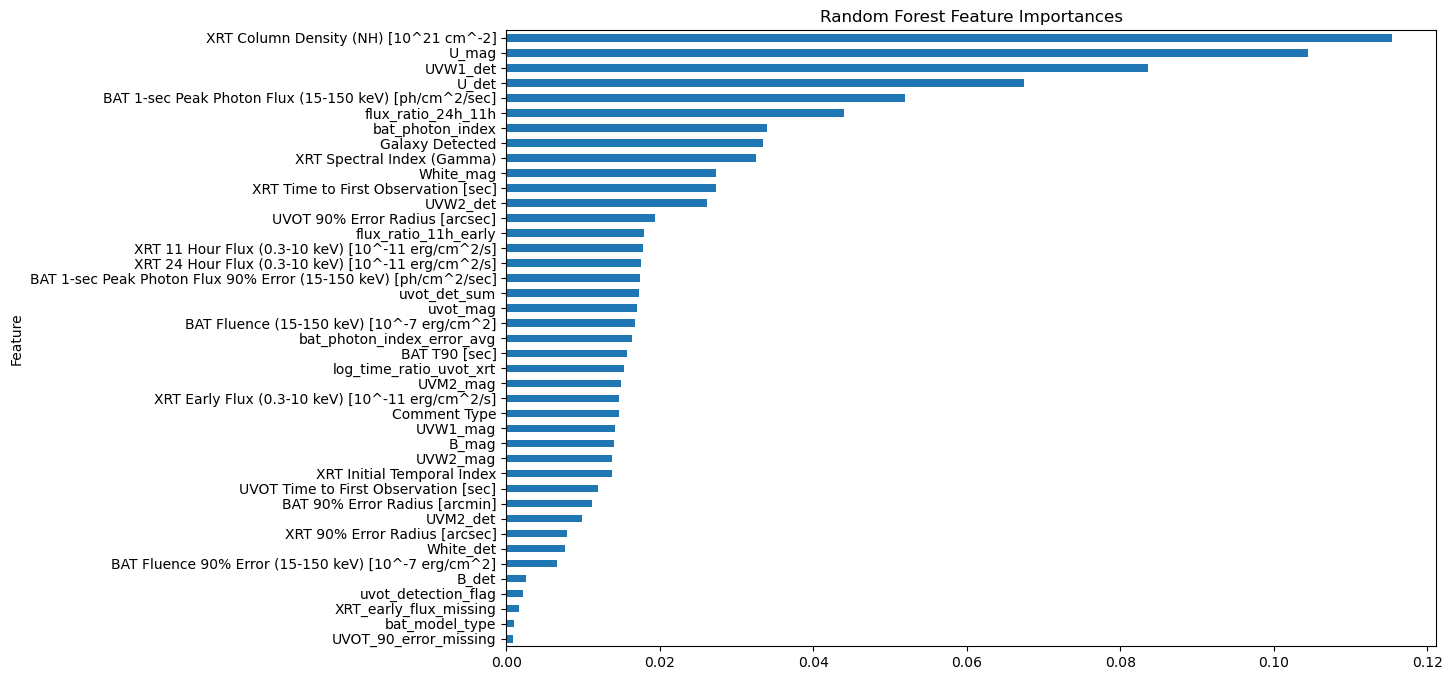

In [ ]:
importances = best_rf.feature_importances_
feature_names = X_initial.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(12, 8))
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()


Cross-Validation Results for Gradient Boosting Regressor
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.70 ± 0.02 | 0.30 ± 0.09  |
| MAE      | 0.57 ± 0.02 | 0.87 ± 0.08  |
| RMSE     | 0.75 ± 0.03 | 1.13 ± 0.10  |


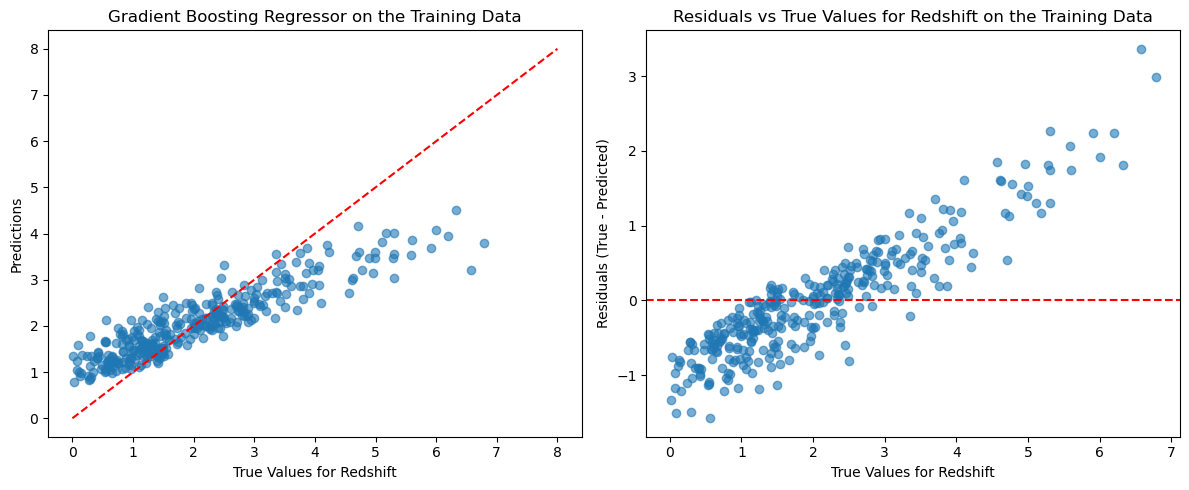

Gradient Boosting Regressor on the full Training Data One Instance
R²: 0.69
MAE: 0.57
RMSE: 0.76


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.03, 
    max_depth=5, 
    min_samples_leaf=10,
)
model_name = "Gradient Boosting Regressor"
model_evaluation(model,model_name, X_scaled,y,kfold)

In [33]:
gbr = GradientBoostingRegressor()
param_grid_gbr = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05],
    'max_depth': [2, 3],
    'min_samples_leaf': [5, 10],
    'subsample': [0.7, 0.9],
    }
grid = GridSearchCV(gbr, param_grid_gbr, cv=kfold, scoring='r2', n_jobs=-1)
grid.fit(X_scaled, y)
best_gbr = grid.best_estimator_
n_estimators = grid.best_params_['n_estimators']
learning_rate = grid.best_params_['learning_rate']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']
subsample = grid.best_params_['subsample']
print('The optimal parameters are for n estimators, learning rate, max depth, min samples leaf, and subsample:', n_estimators, ',', learning_rate, ',', max_depth, ',', min_samples_leaf, ',', subsample)

The optimal parameters are for n estimators, learning rate, max depth, min samples leaf, and subsample: 100 , 0.05 , 3 , 10 , 0.7



Cross-Validation Results for Gradient Boosting Regressor with best parameters
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.78 ± 0.01 | 0.36 ± 0.11  |
| MAE      | 0.48 ± 0.02 | 0.82 ± 0.08  |
| RMSE     | 0.63 ± 0.02 | 1.09 ± 0.12  |


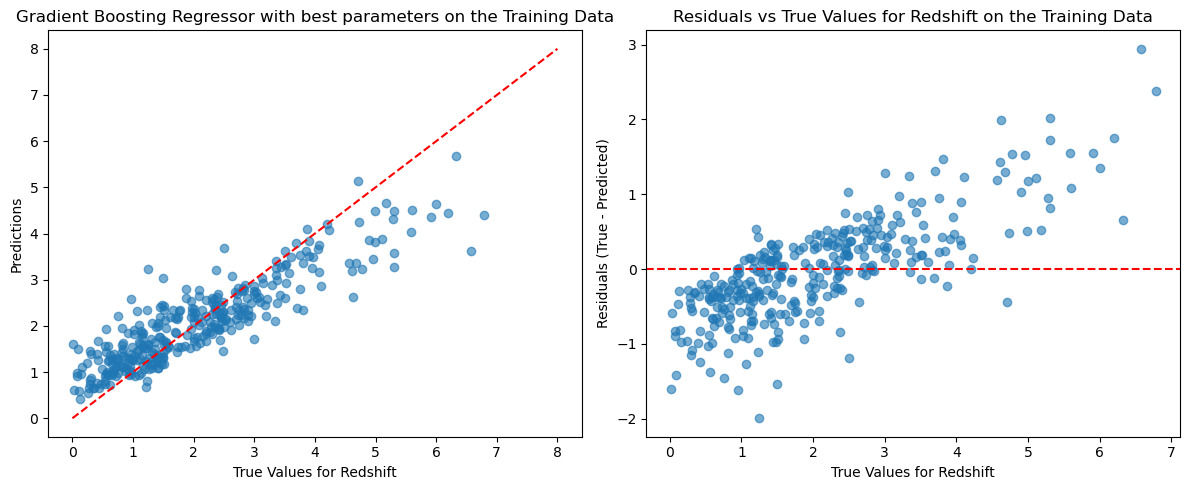

Gradient Boosting Regressor with best parameters on the full Training Data One Instance
R²: 0.76
MAE: 0.51
RMSE: 0.67


In [ ]:
#model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_samples_leaf=min_samples_leaf, subsample=subsample)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, min_samples_leaf=10, subsample=0.7)
model_name = 'Gradient Boosting Regressor with best parameters'
model_evaluation(model,model_name, X_scaled,y,kfold)

In [70]:
evaluate_model_on_test(model, X_test, y_test, scaler)

R²:    0.46
MAE:   0.85
RMSE:  1.11


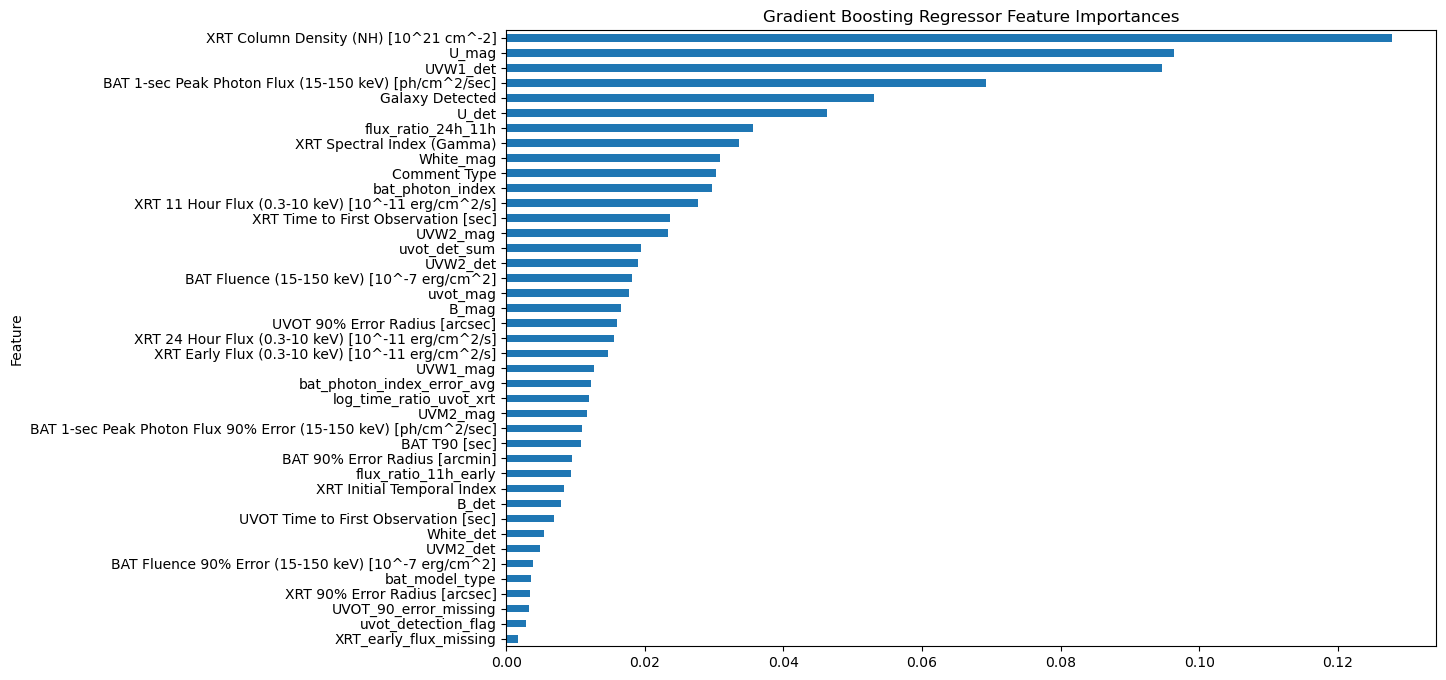

In [ ]:
importances = best_gbr.feature_importances_
feature_names = X_initial.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(12, 8))
plt.title("Gradient Boosting Regressor Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [71]:
!pip install xgboost

In [72]:
import xgboost as xgb
from xgboost import XGBRegressor


Cross-Validation Results for XGBoost Regressor
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 1.00 ± 0.00 | 0.20 ± 0.11  |
| MAE      | 0.00 ± 0.00 | 0.91 ± 0.10  |
| RMSE     | 0.00 ± 0.00 | 1.21 ± 0.12  |


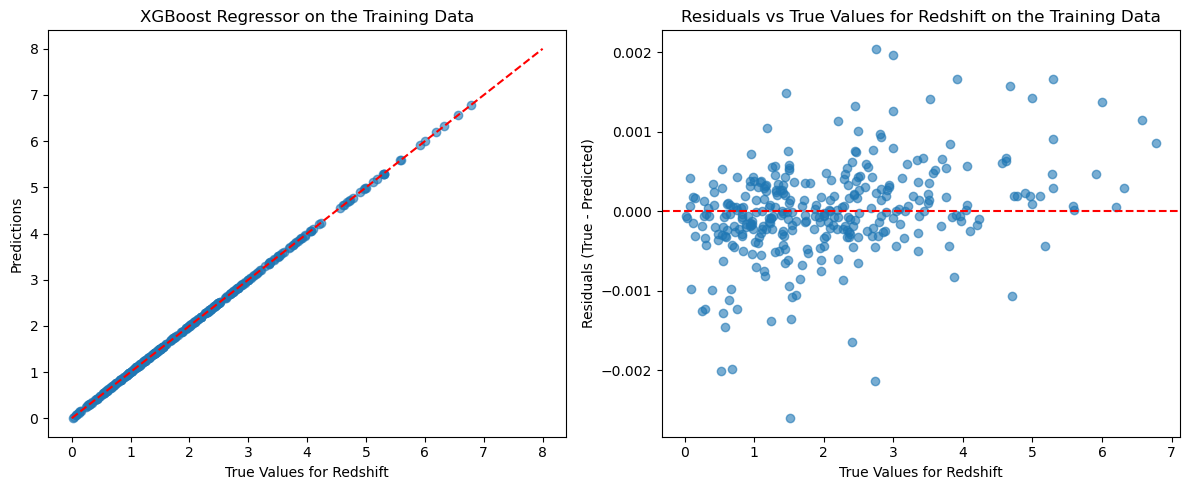

XGBoost Regressor on the full Training Data One Instance
R²: 1.00
MAE: 0.00
RMSE: 0.00


In [ ]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1
)
model_name = 'XGBoost Regressor'
model_evaluation(xgb,model_name, X_scaled,y,kfold)

In [39]:
param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05],
    'max_depth': [2, 3],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 10]
}
grid = GridSearchCV(xgb, param_grid_xgb, cv=kfold, scoring='r2', n_jobs=-1)
grid.fit(X_scaled, y)
best_xgb = grid.best_estimator_
n_estimators = grid.best_params_['n_estimators']
learning_rate = grid.best_params_['learning_rate']
max_depth = grid.best_params_['max_depth']
subsample = grid.best_params_['subsample']
colsample_bytree = grid.best_params_['colsample_bytree']
reg_alpha = grid.best_params_['reg_alpha']
reg_lambda = grid.best_params_['reg_lambda']
print('The optimal parameters are for n estimators, learning rate, max depth, subsample, colsample by tree, reg alpha, and reg lambda:', n_estimators, ',', learning_rate, ',', max_depth, ',', 
      subsample, ',', colsample_bytree, ',', reg_alpha, ',', reg_lambda)


The optimal parameters are for n estimators, learning rate, max depth, subsample, colsample by tree, reg alpha, and reg lambda: 100 , 0.05 , 3 , 0.7 , 0.7 , 0.1 , 10



Cross-Validation Results for XGBoost Regressor with best parameters
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.76 ± 0.01 | 0.37 ± 0.10  |
| MAE      | 0.55 ± 0.01 | 0.88 ± 0.09  |
| RMSE     | 0.72 ± 0.02 | 1.15 ± 0.14  |


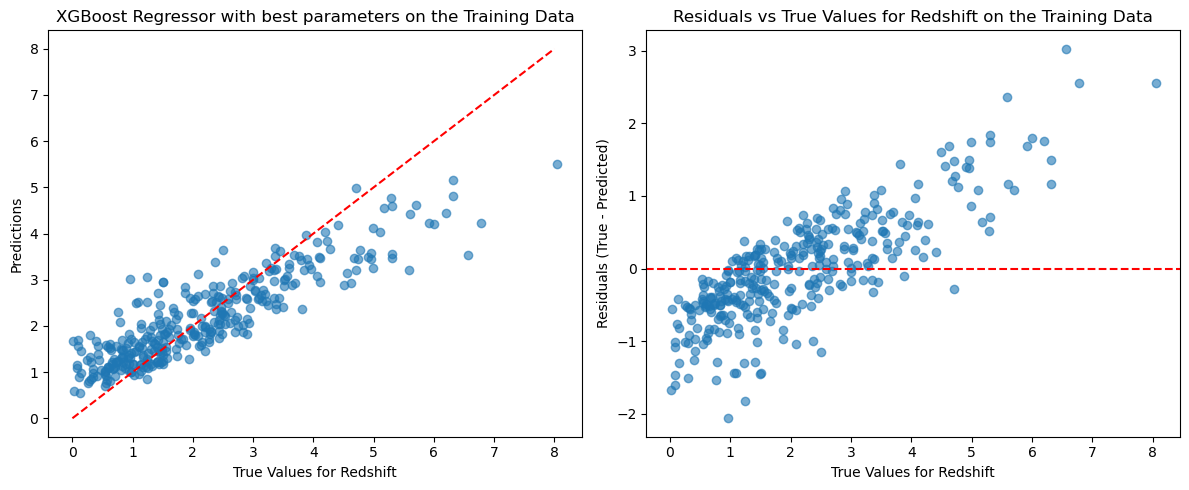

XGBoost Regressor with best parameters on the full Training Data One Instance
R²: 0.74
MAE: 0.57
RMSE: 0.75


In [40]:
model = XGBRegressor(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    objective='reg:squarederror',
    n_jobs=-1
)
model_name = 'XGBoost Regressor with best parameters'
model_evaluation(model,model_name, X_scaled,y,kfold)


Cross-Validation Results for XGBoost Regressor with best parameters
| Metric   | Training    | Validation   |
|----------|-------------|--------------|
| R²       | 0.74 ± 0.01 | 0.30 ± 0.08  |
| MAE      | 0.52 ± 0.02 | 0.87 ± 0.08  |
| RMSE     | 0.70 ± 0.02 | 1.13 ± 0.12  |


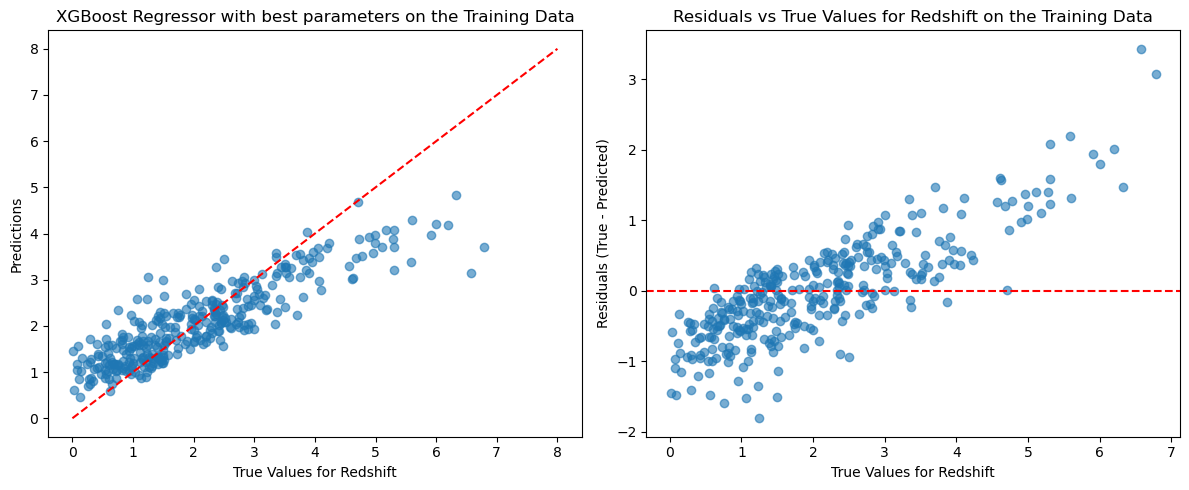

XGBoost Regressor with best parameters on the full Training Data One Instance
R²: 0.71
MAE: 0.55
RMSE: 0.73


In [116]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=10,
    objective='reg:squarederror',
    n_jobs=-1
)
model_name = 'XGBoost Regressor with best parameters'
model_evaluation(model,model_name, X_scaled,y,kfold)

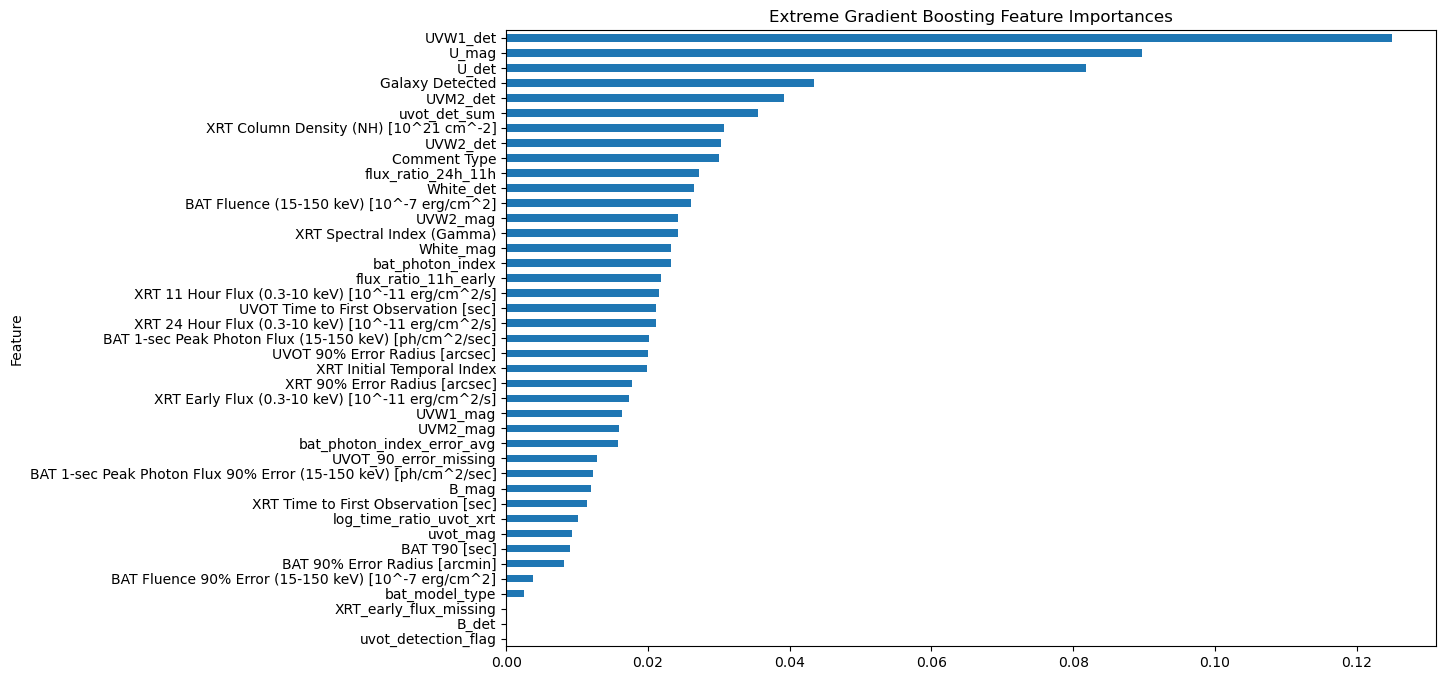

In [117]:
importances = model.feature_importances_
feature_names = X_initial.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(12, 8))
plt.title("Extreme Gradient Boosting Feature Importances")
plt.gca().invert_yaxis()  #helps put the higher importance features at top
plt.show()

In [81]:
evaluate_model_on_test(model, X_test, y_test, scaler)

R²:    0.46
MAE:   0.85
RMSE:  1.11


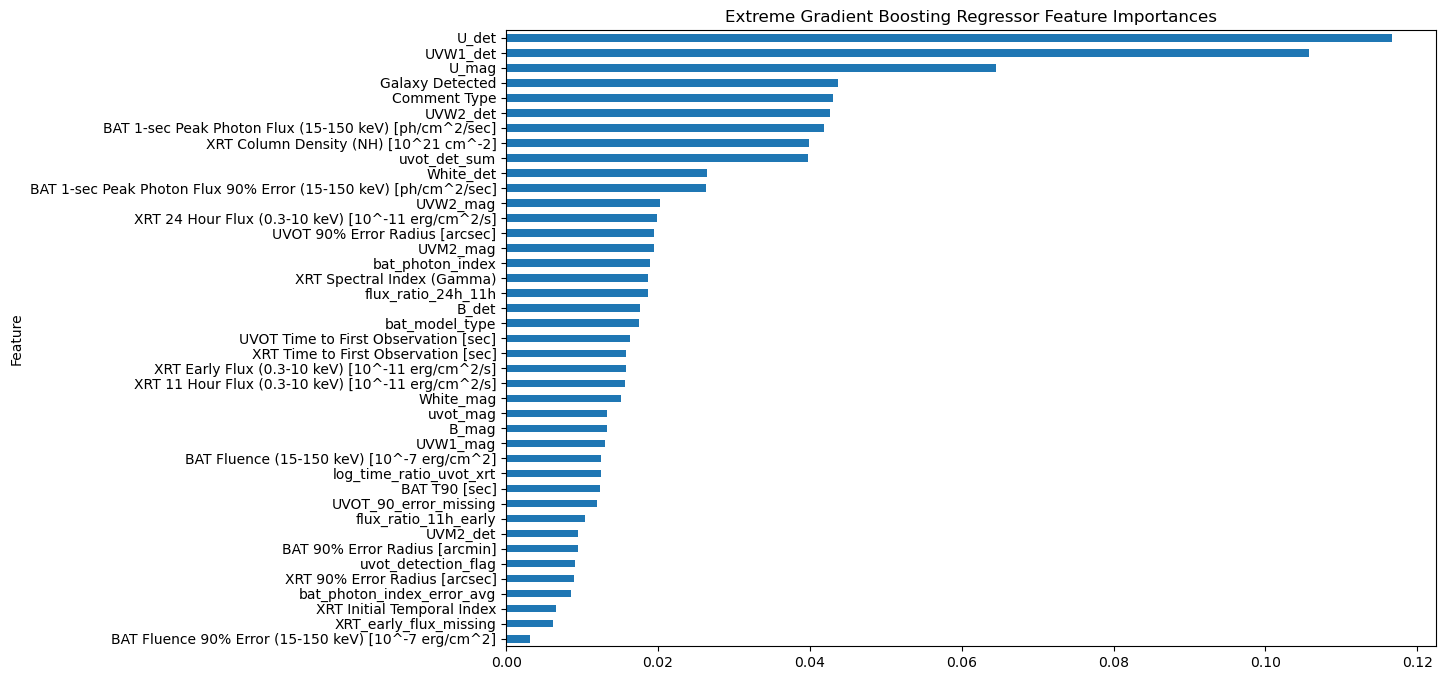

In [ ]:
importances = best_xgb.feature_importances_
feature_names = X_initial.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(12, 8))
plt.title("Extreme Gradient Boosting Regressor Feature Importances")
plt.gca().invert_yaxis()  #helps put the higher importance features at top
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization, Input, Add
from tensorflow.keras.regularizers import l2

In [118]:
print(X_scaled.shape)
print(y.shape)

(335, 41)
(335,)


In [159]:
r2scores_neural_network_train = []
maescores_neural_network_train = []
r2scores_neural_network_val = []
maescores_neural_network_val = []

In [ ]:
print('train r2', np.mean(r2scores_neural_network_train), '±', np.std(r2scores_neural_network_train))
print('train mae', np.mean(maescores_neural_network_train), '±', np.std(maescores_neural_network_train))
print('val r2', np.mean(r2scores_neural_network_val), '±', np.std(r2scores_neural_network_val))
print('val mae', np.mean(maescores_neural_network_val), '±', np.std(maescores_neural_network_val))

train r2 0.6994155129271132 ± 0.0314198254882893
train mae 0.5804500000514407 ± 0.04268578388009897
val r2 0.1595609923018334 ± 0.06255582271692402
val mae 0.9533945440386572 ± 0.034678155157829495


In [121]:
print(len(r2scores_neural_network_train))

0


this means we have 335 datapoints from our original sample size. we are going to further split this data so that we can 
evaluate our data using a neural network.

In [ ]:
#X_scaled excludes the testing data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)    
print(y_val.shape)

(234, 41)
(101, 41)
(234,)
(101,)


In [ ]:
#tanh is better than relu
activation_function='relu'
l2_strength = 0.005
model = Sequential([
    Dense(256, activation=activation_function, input_shape=(X_train.shape[1],), kernel_regularizer=l2(l2_strength)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation=activation_function, kernel_regularizer=l2(l2_strength)),
    BatchNormalization(), #
    Dropout(0.4),
    Dense(128, activation=activation_function, kernel_regularizer=l2(l2_strength)),
    Dense(128, activation=activation_function, kernel_regularizer=l2(l2_strength)), #kernel regularization
    #adds a penalty to the loss function to prevent overfitting, this is proportional to the square of the weights
    Dropout(0.3),
    BatchNormalization(), #
    Dense(64, activation=activation_function, kernel_regularizer=l2(l2_strength)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation=activation_function, kernel_regularizer=l2(l2_strength)),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse', 
              metrics=['mse'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=64,
    verbose=1
)

y_train_pred = model.predict(X_train).flatten()
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

y_val_pred = model.predict(X_val).flatten()
val_r2 = r2_score(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

r2scores_neural_network_train.append(train_r2)
maescores_neural_network_train.append(train_mae)
r2scores_neural_network_val.append(val_r2)
maescores_neural_network_val.append(val_mae)

Epoch 1/70
4/4 [==============================] - 1s 40ms/step - loss: 10.6472 - mse: 6.8806 - val_loss: 9.5894 - val_mse: 5.8220
Epoch 2/70
4/4 [==============================] - 0s 7ms/step - loss: 9.4236 - mse: 5.6557 - val_loss: 9.3862 - val_mse: 5.6174
Epoch 3/70
4/4 [==============================] - 0s 7ms/step - loss: 8.1842 - mse: 4.4148 - val_loss: 9.1374 - val_mse: 5.3670
Epoch 4/70
4/4 [==============================] - 0s 6ms/step - loss: 8.0564 - mse: 4.2856 - val_loss: 8.8674 - val_mse: 5.0959
Epoch 5/70
4/4 [==============================] - 0s 6ms/step - loss: 7.5344 - mse: 3.7626 - val_loss: 8.5722 - val_mse: 4.7999
Epoch 6/70
4/4 [==============================] - 0s 6ms/step - loss: 7.1141 - mse: 3.3416 - val_loss: 8.2812 - val_mse: 4.5084
Epoch 7/70
4/4 [==============================] - 0s 6ms/step - loss: 7.0350 - mse: 3.2622 - val_loss: 7.9797 - val_mse: 4.2068
Epoch 8/70
4/4 [==============================] - 0s 6ms/step - loss: 6.3668 - mse: 2.5940 - val_loss:

'\nprint("R²:", r2_score(y_val, y_pred))\nprint("MAE:", mean_absolute_error(y_val, y_pred))\nprint("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))'

In [171]:
evaluate_model_on_test(model, X_test, y_test, scaler)

3/3 [==============================] - 0s 1ms/step
R²:    0.43
MAE:   0.86
RMSE:  1.14


In [ ]:
model.predict(X_test)

In [123]:
evaluate_model_on_test(model, X_test, y_test, scaler)

3/3 [==============================] - 0s 1ms/step
R²:    -0.08
MAE:   0.88
RMSE:  1.11


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_model():
    activation_function = 'relu'
    l2_strength = 0.001

    model = Sequential([
        Dense(256, activation=activation_function, input_shape=(X_train.shape[1],), kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation=activation_function, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation=activation_function, kernel_regularizer=l2(l2_strength)),
        Dense(128, activation=activation_function, kernel_regularizer=l2(l2_strength)),
        Dropout(0.2),
        BatchNormalization(),
        Dense(64, activation=activation_function, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(32, activation=activation_function, kernel_regularizer=l2(l2_strength)),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mae', 
                  metrics=['mae'])
    return model

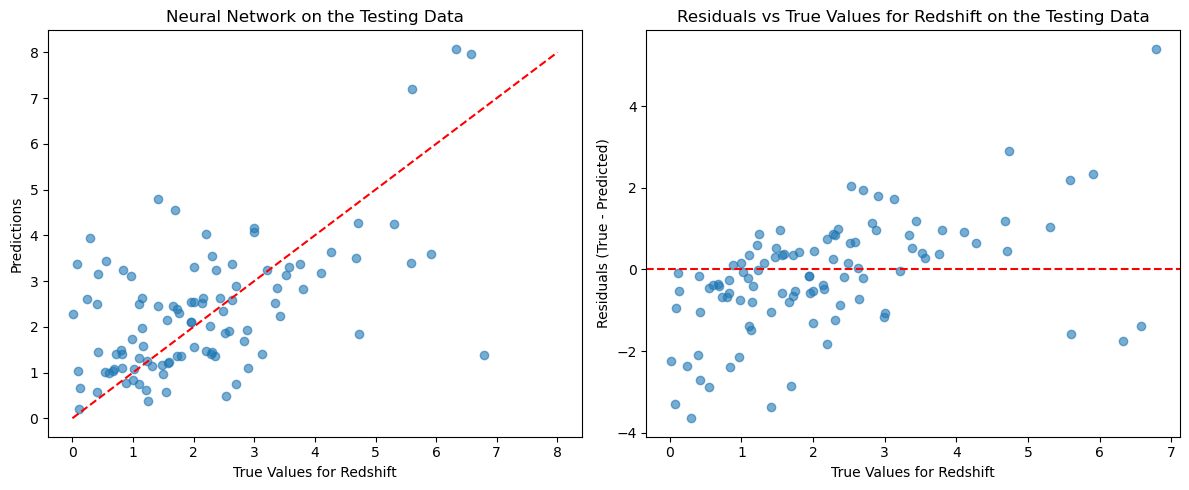

In [46]:
generate_plots(y_val, y_pred, 'Neural Network', 'Testing')

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10752     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

After going through this exercise, I am moderately convinced that a neural network regressor is not feasible for this task.

'''maybe i will use this code in the future

!pip install shap
import shap

explainer = shap.Explainer(model, X_train[:100]) 
shap_values = explainer(X_val[:50])
shap.summary_plot(shap_values, X_val[:50])

'''